<a href="https://colab.research.google.com/github/OsirisEscaL/Parkinson_Project/blob/main/GradientBoostingClassifier_Parkinson_HeredetaryAtaxiasipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, RFE
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE
from sklearn.model_selection import GridSearchCV

In [2]:
ds = pd.read_csv('Parkinson_HeredetaryAtaxias.csv') # Cambiar dataset
ds = ds.drop(['Unnamed: 0'], axis=1)
X = ds.iloc[:, 0:-1].values
y = ds.iloc[:, -1].values

rng = np.random.default_rng(seed=42)
random = rng.integers(10000, size=50)

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

In [3]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(random_state = 42)

In [4]:
results = {}

modelaccuracy = []
modelprecision = []
modelsensitivity = []
modelspecificity = []
modelbalanced_accuracy = []
modelf1 = []
modelroc_auc = []

for rand in random:
    skfaccuracy = []
    skfprecision = []
    skfsensitivity = []
    skfspecificity = []
    skfbalanced_accuracy = []
    skff1 = []
    skfroc_auc = []
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
    for train_index, test_index in stratified_kfold.split(scaled_X, y):
        X_train, X_test = scaled_X[train_index], scaled_X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=1)
        sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
        specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        skfaccuracy.append(accuracy)
        skfprecision.append(precision)
        skfsensitivity.append(sensitivity)
        skfspecificity.append(specificity)
        skfbalanced_accuracy.append(balanced_accuracy)
        skff1.append(f1)
        skfroc_auc.append(roc_auc)
    modelaccuracy.append(np.mean(skfaccuracy))
    modelprecision.append(np.mean(skfprecision))
    modelsensitivity.append(np.mean(skfsensitivity))
    modelspecificity.append(np.mean(skfspecificity))
    modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
    modelf1.append(np.mean(skff1))
    modelroc_auc.append(np.mean(skfroc_auc))
mean_accuracy = np.mean(modelaccuracy)
mean_precision = np.mean(modelprecision)
mean_sensitivity = np.mean(modelsensitivity)
mean_specificity = np.mean(modelspecificity)
mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
mean_f1 = np.mean(modelf1)
mean_roc_auc = np.mean(modelroc_auc)
std_accuracy = np.std(modelaccuracy)
std_precision = np.std(modelprecision)
std_sensitivity = np.std(modelsensitivity)
std_specificity = np.std(modelspecificity)
std_balanced_accuracy = np.std(modelbalanced_accuracy)
std_f1 = np.std(modelf1)
std_roc_auc = np.std(modelroc_auc)
results['GradientBoostingClassifier'] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                                  'Std_Balanced_Accuracy': std_balanced_accuracy,
                                  'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                                  'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                                  'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                                  'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                                  'Mean_F1': mean_f1, 'Std_F1': std_f1,
                                  'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

modelbalanced_accuracy_base = modelbalanced_accuracy
results_ds = pd.DataFrame(results).T
results_ds

,Mean_Accuracy,Mean_Balanced_Accuracy,Mean_F1,Mean_Precision,Mean_ROC_AUC,Mean_Sensitivity,Mean_Specificity,Std_Accuracy,Std_Balanced_Accuracy,Std_F1,Std_Precision,Std_ROC_AUC,Std_Sensitivity,Std_Specificity
GradientBoostingClassifier,0.668857,0.506173,0.785152,0.759404,0.506173,0.823345,0.189,0.040677,0.042853,0.032295,0.020422,0.042853,0.055891,0.082368


Oversampling

In [5]:
methods = [
    ("Random Over Sampler", RandomOverSampler(sampling_strategy='auto', random_state=42)),
    ("SMOTE", SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)),
    ("ADASYN", ADASYN(sampling_strategy='auto', random_state=42, n_neighbors=5)),
    ("BorderlineSMOTE", BorderlineSMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5, m_neighbors=10)),
    ("SVMSMOTE", SVMSMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5, m_neighbors=10)),
    ("KMeansSMOTE", KMeansSMOTE(sampling_strategy='auto', random_state=42, k_neighbors=2, cluster_balance_threshold=0.01))
]

In [6]:
results = {}
results_raw = {}

for method_name, method in methods:
    sample_x, sample_y = method.fit_resample(scaled_X, y)
    modelaccuracy = []
    modelprecision = []
    modelsensitivity = []
    modelspecificity = []
    modelbalanced_accuracy = []
    modelf1 = []
    modelroc_auc = []
    for num in random:
        skfaccuracy = []
        skfprecision = []
        skfsensitivity = []
        skfspecificity = []
        skfbalanced_accuracy = []
        skff1 = []
        skfroc_auc = []
        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=num)
        for train_index, test_index in stratified_kfold.split(sample_x,sample_y):
            X_train, X_test = sample_x[train_index], sample_x[test_index]
            y_train, y_test = sample_y[train_index], sample_y[test_index]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=1)
            sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
            specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
            balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred)
            skfaccuracy.append(accuracy)
            skfprecision.append(precision)
            skfsensitivity.append(sensitivity)
            skfspecificity.append(specificity)
            skfbalanced_accuracy.append(balanced_accuracy)
            skff1.append(f1)
            skfroc_auc.append(roc_auc)
        modelaccuracy.append(np.mean(skfaccuracy))
        modelprecision.append(np.mean(skfprecision))
        modelsensitivity.append(np.mean(skfsensitivity))
        modelspecificity.append(np.mean(skfspecificity))
        modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
        modelf1.append(np.mean(skff1))
        modelroc_auc.append(np.mean(skfroc_auc))
    mean_accuracy = np.mean(modelaccuracy)
    mean_precision = np.mean(modelprecision)
    mean_sensitivity = np.mean(modelsensitivity)
    mean_specificity = np.mean(modelspecificity)
    mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
    mean_f1 = np.mean(modelf1)
    mean_roc_auc = np.mean(modelroc_auc)
    std_accuracy = np.std(modelaccuracy)
    std_precision = np.std(modelprecision)
    std_sensitivity = np.std(modelsensitivity)
    std_specificity = np.std(modelspecificity)
    std_balanced_accuracy = np.std(modelbalanced_accuracy)
    std_f1 = np.std(modelf1)
    std_roc_auc = np.std(modelroc_auc)
    results_raw[method_name] = {'Balanced_Accuracy': modelbalanced_accuracy,
                                'Accuracy': modelaccuracy,
                                'Precision': modelprecision,
                                'Sensitivity': modelsensitivity,
                                'Specificity': modelspecificity,
                                'F1': modelf1,
                                'ROC_AUC': modelroc_auc}
    results[method_name] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                            'Std_Balanced_Accuracy': std_balanced_accuracy,
                            'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                            'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                            'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                            'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                            'Mean_F1': mean_f1, 'Std_F1': std_f1,
                            'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

results_raw_over_ds = pd.DataFrame(results_raw)
results_raw_over_ds.to_csv('Results_Raw_Oversampling_GradientBoostingClassifier.csv')

results_over_ds = pd.DataFrame(results).T
results_over_ds.to_csv('Results_Oversampling_GradientBoostingClassifier.csv')
results_over_ds

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Mean_Balanced_Accuracy,Std_Balanced_Accuracy,Mean_Accuracy,Std_Accuracy,Mean_Precision,Std_Precision,Mean_Sensitivity,Std_Sensitivity,Mean_Specificity,Std_Specificity,Mean_F1,Std_F1,Mean_ROC_AUC,Std_ROC_AUC
Random Over Sampler,0.867982,0.031949,0.867801,0.032268,0.938130,0.043258,0.798545,0.042430,0.937418,0.048220,0.854380,0.034158,0.867982,0.031949
SMOTE,0.824836,0.031684,0.825264,0.031847,0.860124,0.038859,0.789818,0.044465,0.859855,0.038449,0.815466,0.036715,0.824836,0.031684
ADASYN,0.839567,0.028858,0.842364,0.029520,0.904175,0.043220,0.763164,0.036559,0.915970,0.042539,0.821164,0.032003,0.839567,0.028858
BorderlineSMOTE,0.853055,0.030382,0.852797,0.030297,0.891240,0.034262,0.815455,0.049952,0.890655,0.037198,0.844143,0.033573,0.853055,0.030382
SVMSMOTE,0.790823,0.034237,0.796222,0.034613,0.839495,0.029717,0.822218,0.048529,0.759429,0.047314,0.822299,0.035392,0.790823,0.034237
KMeansSMOTE,0.814818,0.030819,0.814719,0.030531,0.836418,0.029608,0.796945,0.047574,0.832691,0.032057,0.807476,0.033952,0.814818,0.030819


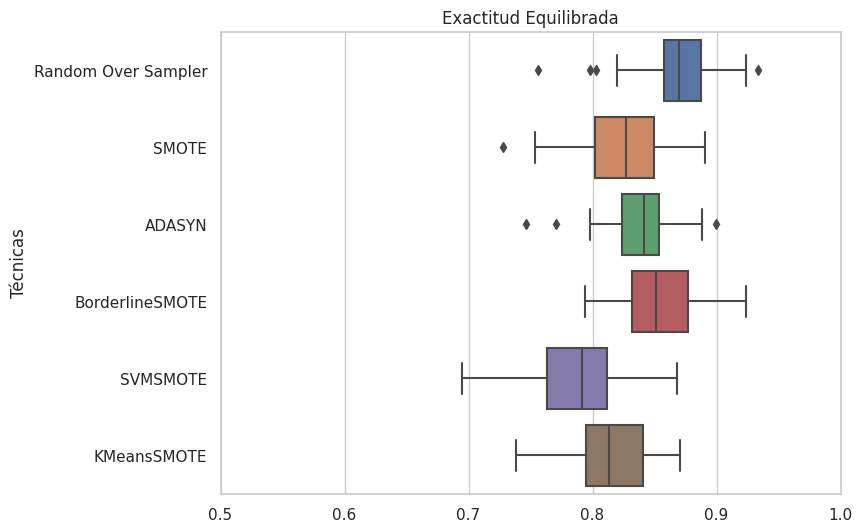

In [7]:
balanced_accuracy = pd.DataFrame(results_raw_over_ds.loc['Balanced_Accuracy'])
modelos = balanced_accuracy.index

plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")
sns.boxplot(data=balanced_accuracy['Balanced_Accuracy'], orient='h')
plt.title('Exactitud Equilibrada')
plt.xlim(0.5, 1)
plt.ylabel('Técnicas')
plt.gca().set_yticklabels(modelos)
plt.savefig('Boxplot_Oversampling_GradientBoostingClassifier.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
samplers = ['Random Over Sampler', 'SMOTE', 'ADASYN', 'BorderlineSMOTE',
            'SVMSMOTE', 'KMeansSMOTE']

comparison = {}
alpha = 0.05
for sample1 in samplers:
  val1 = results_raw_over_ds.loc['Balanced_Accuracy', sample1]
  for sample2 in samplers:
    val2 = results_raw_over_ds.loc['Balanced_Accuracy', sample2]
    statistic, p_value = stats.mannwhitneyu(val1, val2, alternative='two-sided')
    if p_value < alpha:
      statistic, p_value = stats.mannwhitneyu(val1, val2, alternative='greater')
      if p_value < alpha:
        greater = 'La primera muestra es significativamente mayor que la segunda.'
        comparison[sample1, sample2] = {'statistic': statistic,
                                        'p_value': p_value,
                                        'greater': greater}
      else:
        greater = 'La primera muestra no es significativamente mayor que la segunda.'
        comparison[sample1, sample2] = {'statistic': statistic,
                                        'p_value': p_value,
                                        'greater': greater}
    else:
      greater = 'No hay evidencia suficiente para afirmar que las muestras tienen distribuciones diferentes.'
      comparison[sample1, sample2] = {'statistic': statistic,
                                        'p_value': p_value,
                                        'greater': greater}

comparison = pd.DataFrame(comparison).T
comparison.to_csv('MannWhitneyU_Oversampling_GradientBoostingClassifier.csv')
comparison

statistic   p_value  \
Random Over Sampler Random Over Sampler    1250.0       1.0   
                    SMOTE                  2118.0       0.0   
                    ADASYN                 1918.5  0.000002   
                    BorderlineSMOTE        1630.5  0.004396   
                    SVMSMOTE               2366.0       0.0   
                    KMeansSMOTE            2231.5       0.0   
SMOTE               Random Over Sampler     382.0       1.0   
                    SMOTE                  1250.0       1.0   
                    ADASYN                  890.0  0.993529   
                    BorderlineSMOTE         670.0  0.999969   
                    SVMSMOTE               1919.0  0.000002   
                    KMeansSMOTE            1455.5  0.157496   
ADASYN              Random Over Sampler     581.5  0.999998   
                    SMOTE                  1610.0  0.006598   
                    ADASYN                 1250.0       1.0   
                    BorderlineSMOTE         962.5  0.976455   
                    SVMSMOTE               2168.5       0.0   
                    KMeansSMOTE            1809.5  0.000058   
BorderlineSMOTE     Random Over Sampler     869.5  0.995692   
                    SMOTE                  1830.0  0.000032   
                    ADASYN                 1537.5   0.02393   
                    BorderlineSMOTE        1250.0       1.0   
                    SVMSMOTE               2278.0       0.0   
                    KMeansSMOTE            2000.0       0.0   
SVMSMOTE            Random Over Sampler     134.0       1.0   
                    SMOTE                   581.0  0.999998   
                    ADASYN                  331.5       1.0   
                    BorderlineSMOTE         222.0       1.0   
                    SVMSMOTE               1250.0       1.0   
                    KMeansSMOTE             740.0  0.999784   
KMeansSMOTE         Random Over Sampler     268.5       1.0   
                    SMOTE                  1044.5  0.157496   
                    ADASYN                  690.5  0.999943   
                    BorderlineSMOTE         500.0       1.0   
                    SVMSMOTE               1760.0  0.000222   
                    KMeansSMOTE            1250.0       1.0   

                                                                                   greater  
Random Over Sampler Random Over Sampler  No hay evidencia suficiente para afirmar que l...  
                    SMOTE                La primera muestra es significativamente mayor...  
                    ADASYN               La primera muestra es significativamente mayor...  
                    BorderlineSMOTE      La primera muestra es significativamente mayor...  
                    SVMSMOTE             La primera muestra es significativamente mayor...  
                    KMeansSMOTE          La primera muestra es significativamente mayor...  
SMOTE               Random Over Sampler  La primera muestra no es significativamente ma...  
                    SMOTE                No hay evidencia suficiente para afirmar que l...  
                    ADASYN               La primera muestra no es significativamente ma...  
                    BorderlineSMOTE      La primera muestra no es significativamente ma...  
                    SVMSMOTE             La primera muestra es significativamente mayor...  
                    KMeansSMOTE          No hay evidencia suficiente para afirmar que l...  
ADASYN              Random Over Sampler  La primera muestra no es significativamente ma...  
                    SMOTE                La primera muestra es significativamente mayor...  
                    ADASYN               No hay evidencia suficiente para afirmar que l...  
                    BorderlineSMOTE      La primera muestra no es significativamente ma...  
                    SVMSMOTE             La primera muestra es significativamente mayor...  
                    KMeansSMOTE   

In [9]:
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42) # Cambiar dependiendo cual fue mejor
oversample_X, oversample_y = oversampler.fit_resample(scaled_X, y)

In [10]:
results = {}

modelaccuracy = []
modelprecision = []
modelsensitivity = []
modelspecificity = []
modelbalanced_accuracy = []
modelf1 = []
modelroc_auc = []

for rand in random:
    skfaccuracy = []
    skfprecision = []
    skfsensitivity = []
    skfspecificity = []
    skfbalanced_accuracy = []
    skff1 = []
    skfroc_auc = []
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
    for train_index, test_index in stratified_kfold.split(oversample_X,oversample_y):
        X_train, X_test = oversample_X[train_index], oversample_X[test_index]
        y_train, y_test = oversample_y[train_index], oversample_y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=1)
        sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
        specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        skfaccuracy.append(accuracy)
        skfprecision.append(precision)
        skfsensitivity.append(sensitivity)
        skfspecificity.append(specificity)
        skfbalanced_accuracy.append(balanced_accuracy)
        skff1.append(f1)
        skfroc_auc.append(roc_auc)
    modelaccuracy.append(np.mean(skfaccuracy))
    modelprecision.append(np.mean(skfprecision))
    modelsensitivity.append(np.mean(skfsensitivity))
    modelspecificity.append(np.mean(skfspecificity))
    modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
    modelf1.append(np.mean(skff1))
    modelroc_auc.append(np.mean(skfroc_auc))
mean_accuracy = np.mean(modelaccuracy)
mean_precision = np.mean(modelprecision)
mean_sensitivity = np.mean(modelsensitivity)
mean_specificity = np.mean(modelspecificity)
mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
mean_f1 = np.mean(modelf1)
mean_roc_auc = np.mean(modelroc_auc)
std_accuracy = np.std(modelaccuracy)
std_precision = np.std(modelprecision)
std_sensitivity = np.std(modelsensitivity)
std_specificity = np.std(modelspecificity)
std_balanced_accuracy = np.std(modelbalanced_accuracy)
std_f1 = np.std(modelf1)
std_roc_auc = np.std(modelroc_auc)
results['GradientBoostingClassifier'] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                                  'Std_Balanced_Accuracy': std_balanced_accuracy,
                                  'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                                  'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                                  'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                                  'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                                  'Mean_F1': mean_f1, 'Std_F1': std_f1,
                                  'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

modelbalanced_accuracy_over = modelbalanced_accuracy
results_ds = pd.DataFrame(results).T
results_ds

,Mean_Accuracy,Mean_Balanced_Accuracy,Mean_F1,Mean_Precision,Mean_ROC_AUC,Mean_Sensitivity,Mean_Specificity,Std_Accuracy,Std_Balanced_Accuracy,Std_F1,Std_Precision,Std_ROC_AUC,Std_Sensitivity,Std_Specificity
GradientBoostingClassifier,0.867801,0.867982,0.85438,0.93813,0.867982,0.798545,0.937418,0.032268,0.031949,0.034158,0.043258,0.031949,0.04243,0.04822


In [11]:
statistic, p_value = stats.mannwhitneyu(modelbalanced_accuracy_over, modelbalanced_accuracy_base, alternative='two-sided')
if p_value < alpha:
    statistic, p_value = stats.mannwhitneyu(modelbalanced_accuracy_over, modelbalanced_accuracy_base, alternative='greater')
    if p_value < alpha:
        greater = 'La primera muestra es significativamente mayor que la segunda.'
    else:
        greater = 'La primera muestra no es significativamente mayor que la segunda.'
else:
      greater = 'No hay evidencia suficiente para afirmar que las muestras tienen distribuciones diferentes.'
print('statistic:',statistic,'p_value', p_value, greater)

statistic: 2500.0 p_value 3.521896820722099e-18 La primera muestra es significativamente mayor que la segunda.


Feature Selection

In [12]:
ds_X = ds.iloc[:, 0:-1]
features = ds_X.shape[1]

In [14]:
# SelectKBest
results = {}
results_raw = {}

for num in range(1, features):
    selector = SelectKBest(score_func=f_classif, k=num)
    new_X = selector.fit_transform(oversample_X, oversample_y)
    modelaccuracy = []
    modelprecision = []
    modelsensitivity = []
    modelspecificity = []
    modelbalanced_accuracy = []
    modelf1 = []
    modelroc_auc = []
    for rand in random:
        skfaccuracy = []
        skfprecision = []
        skfsensitivity = []
        skfspecificity = []
        skfbalanced_accuracy = []
        skff1 = []
        skfroc_auc = []
        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
        for train_index, test_index in stratified_kfold.split(new_X,oversample_y):
            X_train, X_test = new_X[train_index], new_X[test_index]
            y_train, y_test = oversample_y[train_index], oversample_y[test_index]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=1)
            sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
            specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
            balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred)
            skfaccuracy.append(accuracy)
            skfprecision.append(precision)
            skfsensitivity.append(sensitivity)
            skfspecificity.append(specificity)
            skfbalanced_accuracy.append(balanced_accuracy)
            skff1.append(f1)
            skfroc_auc.append(roc_auc)
        modelaccuracy.append(np.mean(skfaccuracy))
        modelprecision.append(np.mean(skfprecision))
        modelsensitivity.append(np.mean(skfsensitivity))
        modelspecificity.append(np.mean(skfspecificity))
        modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
        modelf1.append(np.mean(skff1))
        modelroc_auc.append(np.mean(skfroc_auc))
    mean_accuracy = np.mean(modelaccuracy)
    mean_precision = np.mean(modelprecision)
    mean_sensitivity = np.mean(modelsensitivity)
    mean_specificity = np.mean(modelspecificity)
    mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
    mean_f1 = np.mean(modelf1)
    mean_roc_auc = np.mean(modelroc_auc)
    std_accuracy = np.std(modelaccuracy)
    std_precision = np.std(modelprecision)
    std_sensitivity = np.std(modelsensitivity)
    std_specificity = np.std(modelspecificity)
    std_balanced_accuracy = np.std(modelbalanced_accuracy)
    std_f1 = np.std(modelf1)
    std_roc_auc = np.std(modelroc_auc)
    results_raw[num-1] = {'Balanced_Accuracy': modelbalanced_accuracy,
                                'Accuracy': modelaccuracy,
                                'Precision': modelprecision,
                                'Sensitivity': modelsensitivity,
                                'Specificity': modelspecificity,
                                'F1': modelf1,
                                'ROC_AUC': modelroc_auc}
    results[num-1] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                            'Std_Balanced_Accuracy': std_balanced_accuracy,
                            'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                            'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                            'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                            'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                            'Mean_F1': mean_f1, 'Std_F1': std_f1,
                            'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

results_raw_selectK_ds = pd.DataFrame(results_raw)
results_raw_selectK_ds.to_csv('Results_Raw_SelectKBest_GradientBoostingClassifier.csv')

results_selectK_ds = pd.DataFrame(results).T
number_of_features = results_selectK_ds.index + 1
results_selectK_ds.insert(0, 'Number_Features', number_of_features)
results_selectK_ds = results_selectK_ds.sort_values(by='Mean_Balanced_Accuracy', ascending=False)
results_selectK_ds.to_csv('Results_SelectKBest_GradientBoostingClassifier.csv')
results_selectK_ds.head(5)

,Number_Features,Mean_Balanced_Accuracy,Std_Balanced_Accuracy,Mean_Accuracy,Std_Accuracy,Mean_Precision,Std_Precision,Mean_Sensitivity,Std_Sensitivity,Mean_Specificity,Std_Specificity,Mean_F1,Std_F1,Mean_ROC_AUC,Std_ROC_AUC
42,43,0.879618,0.031256,0.879541,0.031638,0.951551,0.044124,0.809564,0.039729,0.949673,0.048140,0.867619,0.033273,0.879618,0.031256
40,41,0.876836,0.031114,0.876788,0.031509,0.950368,0.047225,0.804400,0.037764,0.949273,0.051168,0.864140,0.032262,0.876836,0.031114
52,53,0.876691,0.027115,0.876632,0.027318,0.945359,0.043109,0.810436,0.038557,0.942945,0.049124,0.865175,0.028221,0.876691,0.027115
46,47,0.876436,0.029385,0.876216,0.029919,0.948421,0.043785,0.805745,0.035879,0.947127,0.047952,0.863795,0.030567,0.876436,0.029385
5,6,0.876164,0.023989,0.876234,0.024360,0.937691,0.038124,0.815018,0.038077,0.937309,0.042906,0.863938,0.026923,0.876164,0.023989


In [15]:
best_number_K = 43 # Cambiar por el mejor numero de caracteristicas encontradas anteriormente

selector_K = SelectKBest(score_func=f_classif, k=best_number_K)
new_X_K = selector_K.fit_transform(oversample_X, oversample_y)
selected_feature_indices = selector_K.get_support()
selected_feature_names = ds_X.columns[selected_feature_indices]

print("Características seleccionadas usando SelectKBest:")
print(selected_feature_names)

Características seleccionadas usando SelectKBest:
Index(['Cadence_Der', 'Mean_step_lenght_Der', 'Velocity_Der', 'RMS_AP_Der',
       'Freq_50_VER_Der', 'Freq_75_VER_Der', 'Freq_90_VER_Der',
       'Freq_100_VER_Der', 'IPSD_ML_Der', 'Freq_75_ML_Der', 'Freq_90_ML_Der',
       'Freq_100_ML_Der', 'IPSD_AP_Der', 'Freq_50_AP_Der', 'Freq_75_AP_Der',
       'Freq_90_AP_Der', 'Freq_100_AP_Der', 'Sym_VER_Der', 'Sym_AP_Der',
       'Stride_Reg_ML_Der', 'Stride_Reg_AP_Der', 'Step_Reg_VER_Der',
       'Cadence_Izq', 'Mean_step_lenght_Izq', 'Velocity_Izq', 'RMS_VER_Izq',
       'RMS_ML_Izq', 'RMS_AP_Izq', 'IPSD_VER_Izq', 'Freq_50_VER_Izq',
       'Freq_75_VER_Izq', 'Freq_90_VER_Izq', 'Freq_100_VER_Izq', 'IPSD_ML_Izq',
       'Freq_75_ML_Izq', 'Freq_90_ML_Izq', 'Freq_100_ML_Izq', 'IPSD_AP_Izq',
       'Freq_90_AP_Izq', 'Freq_100_AP_Izq', 'Stride_Reg_VER_Izq',
       'Step_Reg_VER_Izq', 'Step_Reg_AP_Izq'],
      dtype='object')


In [16]:
# SelectFromModel
results = {}
results_raw = {}

for num in range(1, features):
    selector = SelectFromModel(model, max_features=num)
    new_X = selector.fit_transform(oversample_X, oversample_y)
    modelaccuracy = []
    modelprecision = []
    modelsensitivity = []
    modelspecificity = []
    modelbalanced_accuracy = []
    modelf1 = []
    modelroc_auc = []
    for rand in random:
        skfaccuracy = []
        skfprecision = []
        skfsensitivity = []
        skfspecificity = []
        skfbalanced_accuracy = []
        skff1 = []
        skfroc_auc = []
        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
        for train_index, test_index in stratified_kfold.split(new_X,oversample_y):
            X_train, X_test = new_X[train_index], new_X[test_index]
            y_train, y_test = oversample_y[train_index], oversample_y[test_index]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=1)
            sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
            specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
            balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred)
            skfaccuracy.append(accuracy)
            skfprecision.append(precision)
            skfsensitivity.append(sensitivity)
            skfspecificity.append(specificity)
            skfbalanced_accuracy.append(balanced_accuracy)
            skff1.append(f1)
            skfroc_auc.append(roc_auc)
        modelaccuracy.append(np.mean(skfaccuracy))
        modelprecision.append(np.mean(skfprecision))
        modelsensitivity.append(np.mean(skfsensitivity))
        modelspecificity.append(np.mean(skfspecificity))
        modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
        modelf1.append(np.mean(skff1))
        modelroc_auc.append(np.mean(skfroc_auc))
    mean_accuracy = np.mean(modelaccuracy)
    mean_precision = np.mean(modelprecision)
    mean_sensitivity = np.mean(modelsensitivity)
    mean_specificity = np.mean(modelspecificity)
    mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
    mean_f1 = np.mean(modelf1)
    mean_roc_auc = np.mean(modelroc_auc)
    std_accuracy = np.std(modelaccuracy)
    std_precision = np.std(modelprecision)
    std_sensitivity = np.std(modelsensitivity)
    std_specificity = np.std(modelspecificity)
    std_balanced_accuracy = np.std(modelbalanced_accuracy)
    std_f1 = np.std(modelf1)
    std_roc_auc = np.std(modelroc_auc)
    results_raw[num-1] = {'Balanced_Accuracy': modelbalanced_accuracy,
                                'Accuracy': modelaccuracy,
                                'Precision': modelprecision,
                                'Sensitivity': modelsensitivity,
                                'Specificity': modelspecificity,
                                'F1': modelf1,
                                'ROC_AUC': modelroc_auc}
    results[num-1] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                            'Std_Balanced_Accuracy': std_balanced_accuracy,
                            'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                            'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                            'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                            'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                            'Mean_F1': mean_f1, 'Std_F1': std_f1,
                            'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

results_raw_select_ds = pd.DataFrame(results_raw)
results_raw_select_ds.to_csv('Results_Raw_SelectM_DecisionTreeClassifier.csv')

results_select_ds = pd.DataFrame(results).T
number_of_features = results_select_ds.index + 1
results_select_ds.insert(0, 'Number_Features', number_of_features)
results_select_ds = results_select_ds.sort_values(by='Mean_Balanced_Accuracy', ascending=False)
results_select_ds.to_csv('Results_SelectM_DecisionTreeClassifier.csv')
results_select_ds.head(5)

,Number_Features,Mean_Balanced_Accuracy,Std_Balanced_Accuracy,Mean_Accuracy,Std_Accuracy,Mean_Precision,Std_Precision,Mean_Sensitivity,Std_Sensitivity,Mean_Specificity,Std_Specificity,Mean_F1,Std_F1,Mean_ROC_AUC,Std_ROC_AUC
3,4,0.907055,0.024367,0.907117,0.024644,0.964166,0.032768,0.852945,0.033289,0.961164,0.036566,0.898806,0.025550,0.907055,0.024367
9,10,0.901727,0.025181,0.901636,0.025273,0.968572,0.036473,0.835782,0.034450,0.967673,0.038621,0.892129,0.026812,0.901727,0.025181
4,5,0.901327,0.026202,0.901281,0.026420,0.962532,0.034481,0.842291,0.030247,0.960364,0.037080,0.892258,0.028461,0.901327,0.026202
6,7,0.899909,0.031446,0.899697,0.031772,0.960035,0.039082,0.841782,0.040671,0.958036,0.044040,0.891451,0.032345,0.899909,0.031446
7,8,0.899327,0.030886,0.899281,0.030926,0.961297,0.039124,0.839127,0.039234,0.959527,0.043556,0.890682,0.031370,0.899327,0.030886


In [17]:
best_number_M = 4 # Cambiar por el mejor numero de caracteristicas encontradas anteriormente

selector_M = SelectFromModel(model, max_features=best_number_M)
new_X_M = selector_M.fit_transform(oversample_X, oversample_y)
selected_feature_indices = selector_M.get_support()
selected_feature_names = ds_X.columns[selected_feature_indices]

print("Características seleccionadas usando SelectFromModel:")
print(selected_feature_names)

Características seleccionadas usando SelectFromModel:
Index(['Velocity_Der', 'RMS_ML_Der', 'RMS_ML_Izq', 'Freq_90_ML_Izq'], dtype='object')


In [18]:
# RFE
results = {}
results_raw = {}

for num in range(1, features):
    selector = RFE(model, n_features_to_select=num)
    new_X = selector.fit_transform(oversample_X, oversample_y)
    modelaccuracy = []
    modelprecision = []
    modelsensitivity = []
    modelspecificity = []
    modelbalanced_accuracy = []
    modelf1 = []
    modelroc_auc = []
    for rand in random:
        skfaccuracy = []
        skfprecision = []
        skfsensitivity = []
        skfspecificity = []
        skfbalanced_accuracy = []
        skff1 = []
        skfroc_auc = []
        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
        for train_index, test_index in stratified_kfold.split(new_X,oversample_y):
            X_train, X_test = new_X[train_index], new_X[test_index]
            y_train, y_test = oversample_y[train_index], oversample_y[test_index]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=1)
            sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
            specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
            balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred)
            skfaccuracy.append(accuracy)
            skfprecision.append(precision)
            skfsensitivity.append(sensitivity)
            skfspecificity.append(specificity)
            skfbalanced_accuracy.append(balanced_accuracy)
            skff1.append(f1)
            skfroc_auc.append(roc_auc)
        modelaccuracy.append(np.mean(skfaccuracy))
        modelprecision.append(np.mean(skfprecision))
        modelsensitivity.append(np.mean(skfsensitivity))
        modelspecificity.append(np.mean(skfspecificity))
        modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
        modelf1.append(np.mean(skff1))
        modelroc_auc.append(np.mean(skfroc_auc))
    mean_accuracy = np.mean(modelaccuracy)
    mean_precision = np.mean(modelprecision)
    mean_sensitivity = np.mean(modelsensitivity)
    mean_specificity = np.mean(modelspecificity)
    mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
    mean_f1 = np.mean(modelf1)
    mean_roc_auc = np.mean(modelroc_auc)
    std_accuracy = np.std(modelaccuracy)
    std_precision = np.std(modelprecision)
    std_sensitivity = np.std(modelsensitivity)
    std_specificity = np.std(modelspecificity)
    std_balanced_accuracy = np.std(modelbalanced_accuracy)
    std_f1 = np.std(modelf1)
    std_roc_auc = np.std(modelroc_auc)
    results_raw[num-1] = {'Balanced_Accuracy': modelbalanced_accuracy,
                                'Accuracy': modelaccuracy,
                                'Precision': modelprecision,
                                'Sensitivity': modelsensitivity,
                                'Specificity': modelspecificity,
                                'F1': modelf1,
                                'ROC_AUC': modelroc_auc}
    results[num-1] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                            'Std_Balanced_Accuracy': std_balanced_accuracy,
                            'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                            'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                            'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                            'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                            'Mean_F1': mean_f1, 'Std_F1': std_f1,
                            'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

results_raw_recursive_ds = pd.DataFrame(results_raw)
results_raw_recursive_ds.to_csv('Results_Raw_RFE_DecisionTreeClassifier.csv')

results_recursive_ds = pd.DataFrame(results).T
number_of_features = results_recursive_ds.index + 1
results_recursive_ds.insert(0, 'Number_Features', number_of_features)
results_recursive_ds = results_recursive_ds.sort_values(by='Mean_Balanced_Accuracy', ascending=False)
results_recursive_ds.to_csv('Results_RFE_DecisionTreeClassifier.csv')
results_recursive_ds.head(5)

,Number_Features,Mean_Balanced_Accuracy,Std_Balanced_Accuracy,Mean_Accuracy,Std_Accuracy,Mean_Precision,Std_Precision,Mean_Sensitivity,Std_Sensitivity,Mean_Specificity,Std_Specificity,Mean_F1,Std_F1,Mean_ROC_AUC,Std_ROC_AUC
4,5,0.910273,0.025657,0.910199,0.025609,0.969439,0.034367,0.853164,0.028841,0.967382,0.037735,0.903011,0.026601,0.910273,0.025657
5,6,0.905655,0.022628,0.905688,0.022668,0.968235,0.032802,0.844764,0.028268,0.966545,0.035126,0.897435,0.023834,0.905655,0.022628
3,4,0.904545,0.021417,0.904597,0.021204,0.964001,0.027143,0.846836,0.026057,0.962255,0.030893,0.895399,0.023433,0.904545,0.021417
6,7,0.899255,0.026020,0.899255,0.026153,0.954512,0.035558,0.845382,0.034524,0.953127,0.038719,0.891554,0.026778,0.899255,0.026020
8,9,0.895527,0.025203,0.895394,0.025425,0.958311,0.033876,0.834036,0.032472,0.957018,0.037178,0.886144,0.027096,0.895527,0.025203


In [19]:
best_number_R = 5 # Cambiar por el mejor numero de caracteristicas encontradas anteriormente

selector_R = RFE(model, n_features_to_select=best_number_R)
new_X_R = selector_R.fit_transform(oversample_X, oversample_y)
selected_feature_indices = selector_R.get_support()
selected_feature_names = ds_X.columns[selected_feature_indices]

print("Características seleccionadas usando SelectFromModel:")
print(selected_feature_names)

Características seleccionadas usando SelectFromModel:
Index(['RMS_ML_Der', 'Sym_AP_Der', 'RMS_ML_Izq', 'Freq_100_VER_Izq',
       'Freq_90_ML_Izq'],
      dtype='object')


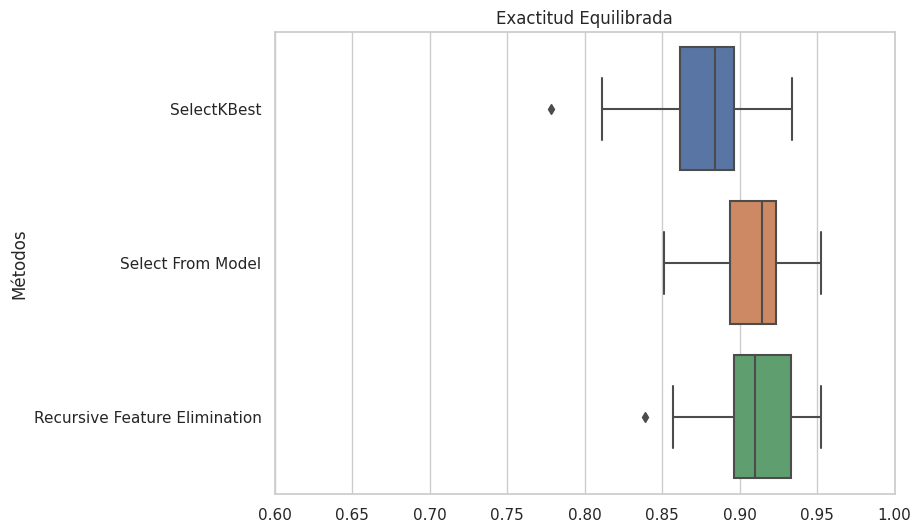

In [20]:
raw_SelectKBest = results_raw_selectK_ds.iloc[0, best_number_K-1]
raw_SelectM = results_raw_select_ds.iloc[0, best_number_M-1]
raw_RFE = results_raw_recursive_ds.iloc[0, best_number_R-1]

raw_SelectKBest = pd.Series(raw_SelectKBest, name='SelectKBest')
raw_SelectM = pd.Series(raw_SelectM, name='Select From Model')
raw_RFE = pd.Series(raw_RFE, name='Recursive Feature Elimination')

FeaturesSelectors = pd.concat([raw_SelectKBest,raw_SelectM, raw_RFE], axis=1)

plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")
sns.boxplot(data=FeaturesSelectors, orient='h')
plt.title('Exactitud Equilibrada')
plt.xlim(0.6, 1)
plt.ylabel('Métodos')
plt.savefig('Boxplot_FeatureSelection_GradientBoostingClassifier.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
samplers = ['SelectKBest', 'Select From Model',
            'Recursive Feature Elimination']

comparison = {}
alpha = 0.05
for sample1 in samplers:
  val1 = FeaturesSelectors.loc[:, sample1]
  for sample2 in samplers:
    val2 = FeaturesSelectors.loc[:, sample2]
    statistic, p_value = stats.mannwhitneyu(val1, val2, alternative='two-sided')
    if p_value < alpha:
      statistic, p_value = stats.mannwhitneyu(val1, val2, alternative='greater')
      if p_value < alpha:
        greater = 'La primera muestra es significativamente mayor que la segunda.'
        comparison[sample1, sample2] = {'statistic': statistic,
                                        'p_value': p_value,
                                        'greater': greater}
      else:
        greater = 'La primera muestra no es significativamente mayor que la segunda.'
        comparison[sample1, sample2] = {'statistic': statistic,
                                        'p_value': p_value,
                                        'greater': greater}
    else:
      greater = 'No hay evidencia suficiente para afirmar que las muestras tienen distribuciones diferentes.'
      comparison[sample1, sample2] = {'statistic': statistic,
                                        'p_value': p_value,
                                        'greater': greater}

comparison = pd.DataFrame(comparison).T
comparison.to_csv('MannWhitneyU_FeaturesSelection_GradientBoostingClassifier.csv')
comparison

statistic  \
SelectKBest                   SelectKBest                      1250.0   
                              Select From Model                 611.5   
                              Recursive Feature Elimination     537.5   
Select From Model             SelectKBest                      1888.5   
                              Select From Model                1250.0   
                              Recursive Feature Elimination    1177.0   
Recursive Feature Elimination SelectKBest                      1962.5   
                              Select From Model                1323.0   
                              Recursive Feature Elimination    1250.0   

                                                              p_value  \
SelectKBest                   SelectKBest                         1.0   
                              Select From Model              0.999995   
                              Recursive Feature Elimination       1.0   
Select From Model             SelectKBest                    0.000005   
                              Select From Model                   1.0   
                              Recursive Feature Elimination  0.617042   
Recursive Feature Elimination SelectKBest                         0.0   
                              Select From Model              0.617042   
                              Recursive Feature Elimination       1.0   

                                                                                                       greater  
SelectKBest                   SelectKBest                    No hay evidencia suficiente para afirmar que l...  
                              Select From Model              La primera muestra no es significativamente ma...  
                              Recursive Feature Elimination  La primera muestra no es significativamente ma...  
Select From Model             SelectKBest                    La primera muestra es significativamente mayor...  
                              Select From Model              No hay evidencia suficiente para afirmar que l...  
                              Recursive Feature Elimination  No hay evidencia suficiente para afirmar que l...  
Recursive Feature Elimination SelectKBest                    La primera muestra es significativamente mayor...  
                              Select From Model              No hay evidencia suficiente para afirmar que l...  
                              Recursive Feature Elimination  No hay evidencia suficiente para afirmar que l...

In [22]:
best_number_R = 5 # Cambiar por el mejor numero de caracteristicas encontradas anteriormente

selector = RFE(model, n_features_to_select=best_number_R)# Cambiar dependiendo cual fue mejor
new_X = selector.fit_transform(oversample_X, oversample_y)

In [23]:
results = {}

modelaccuracy = []
modelprecision = []
modelsensitivity = []
modelspecificity = []
modelbalanced_accuracy = []
modelf1 = []
modelroc_auc = []

for rand in random:
    skfaccuracy = []
    skfprecision = []
    skfsensitivity = []
    skfspecificity = []
    skfbalanced_accuracy = []
    skff1 = []
    skfroc_auc = []
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
    for train_index, test_index in stratified_kfold.split(new_X,oversample_y):
        X_train, X_test = new_X[train_index], new_X[test_index]
        y_train, y_test = oversample_y[train_index], oversample_y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=1)
        sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
        specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        skfaccuracy.append(accuracy)
        skfprecision.append(precision)
        skfsensitivity.append(sensitivity)
        skfspecificity.append(specificity)
        skfbalanced_accuracy.append(balanced_accuracy)
        skff1.append(f1)
        skfroc_auc.append(roc_auc)
    modelaccuracy.append(np.mean(skfaccuracy))
    modelprecision.append(np.mean(skfprecision))
    modelsensitivity.append(np.mean(skfsensitivity))
    modelspecificity.append(np.mean(skfspecificity))
    modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
    modelf1.append(np.mean(skff1))
    modelroc_auc.append(np.mean(skfroc_auc))
mean_accuracy = np.mean(modelaccuracy)
mean_precision = np.mean(modelprecision)
mean_sensitivity = np.mean(modelsensitivity)
mean_specificity = np.mean(modelspecificity)
mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
mean_f1 = np.mean(modelf1)
mean_roc_auc = np.mean(modelroc_auc)
std_accuracy = np.std(modelaccuracy)
std_precision = np.std(modelprecision)
std_sensitivity = np.std(modelsensitivity)
std_specificity = np.std(modelspecificity)
std_balanced_accuracy = np.std(modelbalanced_accuracy)
std_f1 = np.std(modelf1)
std_roc_auc = np.std(modelroc_auc)
results['GradientBoostingClassifier'] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                                  'Std_Balanced_Accuracy': std_balanced_accuracy,
                                  'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                                  'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                                  'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                                  'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                                  'Mean_F1': mean_f1, 'Std_F1': std_f1,
                                  'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

modelbalanced_accuracy_select = modelbalanced_accuracy
results_ds = pd.DataFrame(results).T
results_ds

,Mean_Accuracy,Mean_Balanced_Accuracy,Mean_F1,Mean_Precision,Mean_ROC_AUC,Mean_Sensitivity,Mean_Specificity,Std_Accuracy,Std_Balanced_Accuracy,Std_F1,Std_Precision,Std_ROC_AUC,Std_Sensitivity,Std_Specificity
GradientBoostingClassifier,0.910199,0.910273,0.903011,0.969439,0.910273,0.853164,0.967382,0.025609,0.025657,0.026601,0.034367,0.025657,0.028841,0.037735


In [24]:
statistic, p_value = stats.mannwhitneyu(modelbalanced_accuracy_select, modelbalanced_accuracy_over, alternative='two-sided')
if p_value < alpha:
    statistic, p_value = stats.mannwhitneyu(modelbalanced_accuracy_select, modelbalanced_accuracy_over, alternative='greater')
    if p_value < alpha:
        greater = 'La primera muestra es significativamente mayor que la segunda.'
    else:
        greater = 'La primera muestra no es significativamente mayor que la segunda.'
else:
      greater = 'No hay evidencia suficiente para afirmar que las muestras tienen distribuciones diferentes.'
print('statistic:',statistic,'p_value', p_value, greater)

statistic: 2165.0 p_value 1.435488115930092e-10 La primera muestra es significativamente mayor que la segunda.


Hyperparameter Tunning

In [25]:
parameters = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(estimator=model, param_grid=parameters, cv=50,  scoring='balanced_accuracy')
grid_search.fit(new_X, oversample_y)

print("Mejores hiperparámetros:", grid_search.best_params_)

Mejores hiperparámetros: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50, 'subsample': 1.0}


In [26]:
model_hyper = GradientBoostingClassifier(learning_rate= 0.1, max_depth= 3, min_samples_leaf= 1,
                                         min_samples_split= 10, n_estimators= 50, subsample= 1.0, random_state = 42)

In [27]:
results = {}

modelaccuracy = []
modelprecision = []
modelsensitivity = []
modelspecificity = []
modelbalanced_accuracy = []
modelf1 = []
modelroc_auc = []

for rand in random:
    skfaccuracy = []
    skfprecision = []
    skfsensitivity = []
    skfspecificity = []
    skfbalanced_accuracy = []
    skff1 = []
    skfroc_auc = []
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
    for train_index, test_index in stratified_kfold.split(new_X,oversample_y):
        X_train, X_test = new_X[train_index], new_X[test_index]
        y_train, y_test = oversample_y[train_index], oversample_y[test_index]
        model_hyper.fit(X_train, y_train)
        y_pred = model_hyper.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=1)
        sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
        specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        skfaccuracy.append(accuracy)
        skfprecision.append(precision)
        skfsensitivity.append(sensitivity)
        skfspecificity.append(specificity)
        skfbalanced_accuracy.append(balanced_accuracy)
        skff1.append(f1)
        skfroc_auc.append(roc_auc)
    modelaccuracy.append(np.mean(skfaccuracy))
    modelprecision.append(np.mean(skfprecision))
    modelsensitivity.append(np.mean(skfsensitivity))
    modelspecificity.append(np.mean(skfspecificity))
    modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
    modelf1.append(np.mean(skff1))
    modelroc_auc.append(np.mean(skfroc_auc))
mean_accuracy = np.mean(modelaccuracy)
mean_precision = np.mean(modelprecision)
mean_sensitivity = np.mean(modelsensitivity)
mean_specificity = np.mean(modelspecificity)
mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
mean_f1 = np.mean(modelf1)
mean_roc_auc = np.mean(modelroc_auc)
std_accuracy = np.std(modelaccuracy)
std_precision = np.std(modelprecision)
std_sensitivity = np.std(modelsensitivity)
std_specificity = np.std(modelspecificity)
std_balanced_accuracy = np.std(modelbalanced_accuracy)
std_f1 = np.std(modelf1)
std_roc_auc = np.std(modelroc_auc)
results['DecisionTreeClassifier'] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                                  'Std_Balanced_Accuracy': std_balanced_accuracy,
                                  'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                                  'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                                  'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                                  'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                                  'Mean_F1': mean_f1, 'Std_F1': std_f1,
                                  'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

modelbalanced_accuracy_hyper = modelbalanced_accuracy
results_ds = pd.DataFrame(results).T
results_ds

,Mean_Accuracy,Mean_Balanced_Accuracy,Mean_F1,Mean_Precision,Mean_ROC_AUC,Mean_Sensitivity,Mean_Specificity,Std_Accuracy,Std_Balanced_Accuracy,Std_F1,Std_Precision,Std_ROC_AUC,Std_Sensitivity,Std_Specificity
DecisionTreeClassifier,0.908641,0.908727,0.9009,0.966891,0.908727,0.852291,0.965164,0.026979,0.026744,0.028645,0.037192,0.026744,0.030475,0.039381


In [28]:
statistic, p_value = stats.mannwhitneyu(modelbalanced_accuracy_hyper, modelbalanced_accuracy_select, alternative='two-sided')
if p_value < alpha:
    statistic, p_value = stats.mannwhitneyu(modelbalanced_accuracy_hyper, modelbalanced_accuracy_select, alternative='greater')
    if p_value < alpha:
        greater = 'La primera muestra es significativamente mayor que la segunda.'
    else:
        greater = 'La primera muestra no es significativamente mayor que la segunda.'
else:
      greater = 'No hay evidencia suficiente para afirmar que las muestras tienen distribuciones diferentes.'
print('statistic:',statistic,'p_value', p_value, greater)

statistic: 1206.5 p_value 0.7668026527010658 No hay evidencia suficiente para afirmar que las muestras tienen distribuciones diferentes.


Resultados y Curva ROC

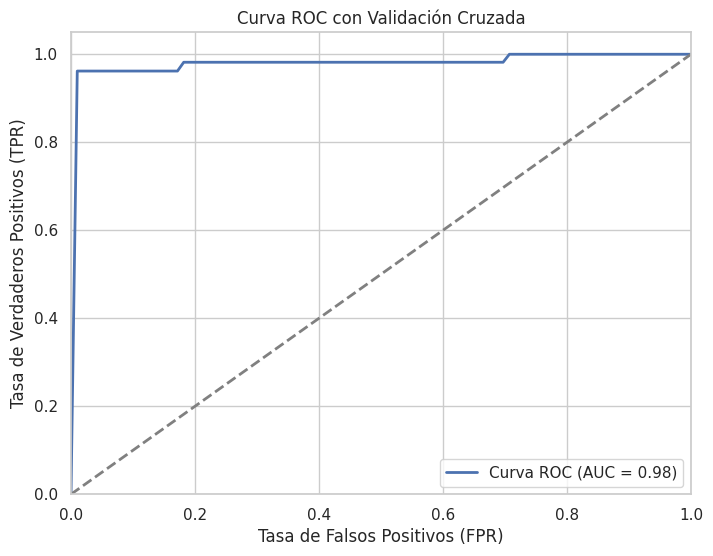

In [32]:
model_best = model #Cambie para colocar el parametro probability
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
mean_fpr = np.linspace(0, 1, 100)
tprs = []

for train_index, test_index in cv.split(new_X, oversample_y):
    X_train, X_test = new_X[train_index], new_X[test_index]
    y_train, y_test = oversample_y[train_index], oversample_y[test_index]
    model_best.fit(X_train, y_train)
    y_pred_prob = model_best.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)

mean_tpr = np.mean(tprs, axis=0)
roc_auc = auc(mean_fpr, mean_tpr)

plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, color='b', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC con Validación Cruzada')
plt.legend(loc='lower right')
plt.savefig('ROCCurve_GradientBoostingClassifier.png', dpi=300, bbox_inches='tight')
plt.show()